In [2]:
from google.colab import drive
drive.mount('/content/drive') # Changed the mountpoint to a valid path without spaces

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/Dataset/Gold Futures Historical Data.csv', 'r') as f:
  data = f.read()
print(data)

﻿"Date","Price","Open","High","Low","Vol.","Change %"
"11/08/2024","2,694.80","2,713.60","2,717.80","2,687.30","","-0.41%"
"11/07/2024","2,705.80","2,667.70","2,718.30","2,650.30","292.92K","1.10%"
"11/06/2024","2,676.30","2,752.60","2,758.80","2,660.70","361.31K","-2.67%"
"11/05/2024","2,749.70","2,746.00","2,759.50","2,733.40","151.43K","0.13%"
"11/04/2024","2,746.20","2,743.50","2,757.50","2,739.40","145.25K","-0.11%"
"11/01/2024","2,749.20","2,754.00","2,772.40","2,742.60","180.66K","0.00%"
"10/31/2024","2,749.30","2,799.10","2,801.20","2,741.80","242.57K","-1.84%"
"10/30/2024","2,800.80","2,786.90","2,801.80","2,782.40","191.55K","1.16%"
"10/29/2024","2,768.80","2,741.90","2,773.20","2,741.90","0.85K","0.47%"
"10/28/2024","2,755.90","2,749.20","2,758.30","2,736.90","161.91K","0.50%"
"10/25/2024","2,742.20","2,735.40","2,747.20","2,716.90","0.26K","-0.24%"
"10/24/2024","2,748.90","2,729.20","2,756.30","2,728.70","175.87K","0.71%"
"10/23/2024","2,729.40","2,762.60","2,772.60","2,722

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


# PREPROCESSING DATA

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/Gold Futures Historical Data.csv')
df = df[['Price']]
# Format column Price to float
df['Price'] = df.Price.str.replace(',','').astype(float)

# Flip the column
df = df.iloc[::-1]

# Drop missing values
df = df.dropna()

# Reset the index
df = df.reset_index(drop=True)

# SPLITTING DATA(7-2-1)

In [5]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [6]:
!pip install pmdarima --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.0 MB/s eta 0:00:00


In [7]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', stepwise=True, suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7682.769, Time=5.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7682.602, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7683.667, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7683.654, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7681.143, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7683.113, Time=3.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 9.918 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [8]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [9]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1953.2 1953.2 1953.2 1953.2 1953.2 1953.2 1953.2 1953.2 1953.2 1953.2
 1953.2 1953.2 1953.2 1953.2 1953.2 1953.2 1953.2 1953.2 1953.2 1953.2
 1953.2 1953.2 1953.2 1953.2 1953.2 1953.2 1953.2 1953.2 1953.2 1953.2]


In [11]:
# Calculate the accuracy for each model

from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  165.24553367640542
Testing MAE:  108.7400000000001
Testing MAPE:  4.98557486056808
Validation RMSE:  570.8984337459191
Validation MAE:  553.4952755905516
Validation MAPE:  21.842530518291447


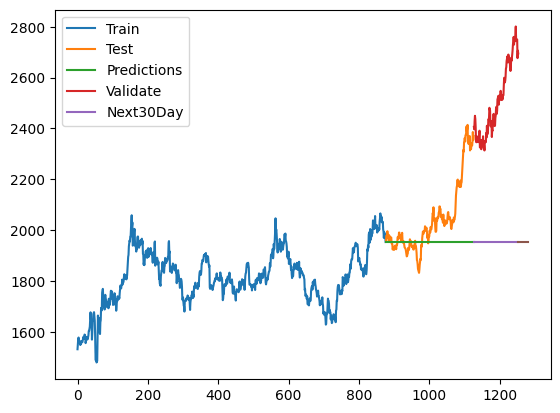

In [12]:
# Plot
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Price'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  877
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3839.572
Date:                Mon, 11 Nov 2024   AIC                           7681.143
Time:                        06:01:29   BIC                           7685.919
Sample:                             0   HQIC                          7682.970
                                - 877                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       375.5056     11.122     33.762      0.000     353.707     397.304
===================================================================================
Ljung-Box (L1) (Q):                   0.94   Jarque-Bera (JB):               404.50
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# SPLITTING DATA(6-3-1)

In [14]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [15]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6593.755, Time=1.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6593.213, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6594.783, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6594.795, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6591.378, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6596.736, Time=0.37 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.711 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [16]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [17]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1748.1 1748.1 1748.1 1748.1 1748.1 1748.1 1748.1 1748.1 1748.1 1748.1
 1748.1 1748.1 1748.1 1748.1 1748.1 1748.1 1748.1 1748.1 1748.1 1748.1
 1748.1 1748.1 1748.1 1748.1 1748.1 1748.1 1748.1 1748.1 1748.1 1748.1]


In [18]:
# Calculate accurary for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  289.5694801880596
Testing MAE:  254.74601063829795
Testing MAPE:  12.333481005979612
Validation RMSE:  772.2203069463517
Validation MAE:  759.3960317460319
Validation MAPE:  30.071145068214655


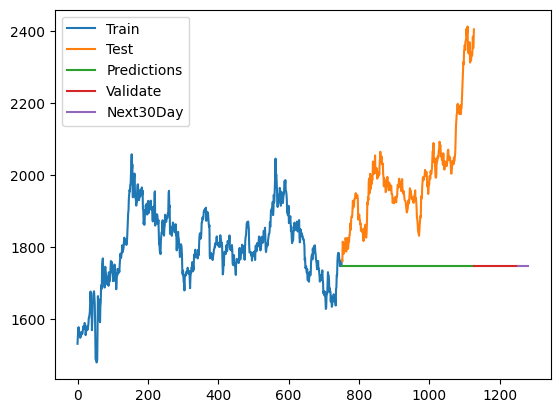

In [19]:
# Plot
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

# SPLITTING DATA(5-3-**1**)

In [20]:
# Split the data into training, testing, and validation sets
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [21]:
# Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5540.262, Time=5.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5538.745, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5540.358, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5540.359, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5537.130, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5542.358, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 5.928 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [22]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [23]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1843.7 1843.7 1843.7 1843.7 1843.7 1843.7 1843.7 1843.7 1843.7 1843.7
 1843.7 1843.7 1843.7 1843.7 1843.7 1843.7 1843.7 1843.7 1843.7 1843.7
 1843.7 1843.7 1843.7 1843.7 1843.7 1843.7 1843.7 1843.7 1843.7 1843.7]


In [24]:
# Calculate accuracy for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  114.743273339206
Testing MAE:  100.46436170212766
Testing MAPE:  5.391465206484882
Validation RMSE:  533.9450787967942
Validation MAE:  482.83426294820714
Validation MAPE:  19.98988180946876


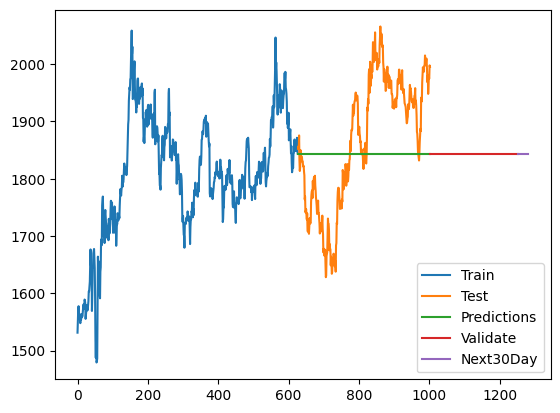

In [25]:
# Plot
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()